In [ ]:
pip install -q torch transformers pandas numpy tqdm matplotlib

In [1]:
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import pandas as pd
import numpy as np
import json

class Dataset(Dataset):
    #creates a torch dataset object for the csv file
    def __init__(self, df):
        self.dataset_df = df
    def __len__(self):
        return len(self.dataset_df)
    def __str2tensor__(self,word_emb):
        #takes the str in the cell word_embeddings and transformed to a json file,then a numpy array format float32 and then a torch.float
        word_emb = json.loads(word_emb)
        word_emb = np.array(word_emb, dtype=np.float32)
        return torch.tensor(word_emb)
    def __getitem__(self, idx):
        _, _, _, _,label ,word_embeddings = self.dataset_df.iloc[idx]
        return self.__str2tensor__(word_embeddings),torch.tensor(label,dtype = torch.float)

In [2]:
dataset_name = '50000_samples.csv'
df = pd.read_csv(dataset_name)
dataset = Dataset(df)

In [3]:
def validation(data_loader, model):
    #returns accuracy
    device = "cuda" if torch.cuda.is_available() else "cpu"
    cnn.eval()
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device),targets.unsqueeze(1).to(device)
            preds = cnn(inputs)
            predicted = torch.where(preds >= 0.5, torch.tensor(1.0), torch.tensor(0.0))
            correct_preds += (predicted == targets).sum().item()
            total_preds += targets.size(0)
    accuracy = correct_preds / total_preds
    cnn.train()
    return accuracy

In [4]:
import torch.nn as nn
class ANNc(nn.Module):
    def __init__(self, emb_size=1024, **kwargs):
        '''CNN based analogy classifier model.

        It generates a value between 0 and 1 (0 for invalid, 1 for valid) based on four input vectors.
        1st layer (convolutional): 128 filters (= kernels) of size h × w = 1 × 2 with strides (1, 2) and relu activation.
        2nd layer (convolutional): 64 filters of size (2, 2) with strides (2, 2) and relu activation.
        3rd layer (dense, equivalent to linear for PyTorch): one output and sigmoid activation.

        Argument:
        emb_size -- the size of the input vectors'''
        super().__init__()
        self.emb_size = emb_size
        self.conv1 = nn.Conv2d(1, 128, (1,2), stride=(1,2))
        self.conv2 = nn.Conv2d(128, 64, (2,2), stride=(2,2))
        self.linear = nn.Linear(64*(emb_size//2), 1)

    def flatten(self, t):
        '''Flattens the input tensor.'''
        t = t.reshape(t.size()[0], -1)
        return t

    def forward(self,image, p=0):
        """
        
        Expected input shape:
        - a, b, c, d: [batch_size, emb_size]
        """
        #image = torch.stack([a, b, c, d], dim = 2)

        # apply dropout
        if p>0:
            image=F.dropout(image, p)

        x = self.conv1(image.unsqueeze(-3))
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.flatten(x)
        x = self.linear(x)
        output = torch.sigmoid(x)
        return output

In [5]:
def save_model(model,optimizer,file_name='ANNc.pth.tar'):
    #saves model and optimizer 
    checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    torch.save(checkpoint, file_name)

In [6]:
import matplotlib.pyplot as plt 
def plot(scores,score_name):
    #uses plt to plot the progressiong the score
    ploting_epochs = range(1, len(scores) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(ploting_epochs, scores, marker='o', color='b', label=score_name)
    plt.xlabel('Epochs')
    plt.ylabel('score')
    plt.title(f'{score_name} overtime')
    plt.grid(True)
    plt.legend()
    plt.show()

In [7]:
#load model,dataloaders and more hyper-parameters
from torch.utils.data import DataLoader,random_split
from tqdm import trange

#dataloader
batch_size = 100
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])
train_set= DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_set = DataLoader(test_set, batch_size=batch_size,shuffle=True)

#load model
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
cnn = ANNc().to(device)

#load opt
lr = 0.000001
opt = torch.optim.Adam(cnn.parameters(),lr=lr)

#load loss function
loss_fn = nn.BCELoss()

validation accuracy: 0.84,training loss : 0.30: 100%|█| 100/100 [1:29:22<00:00, 


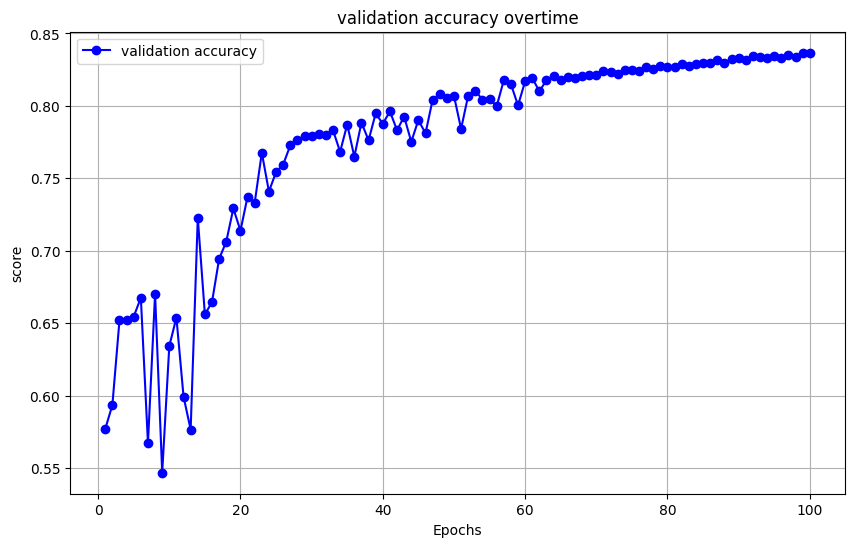

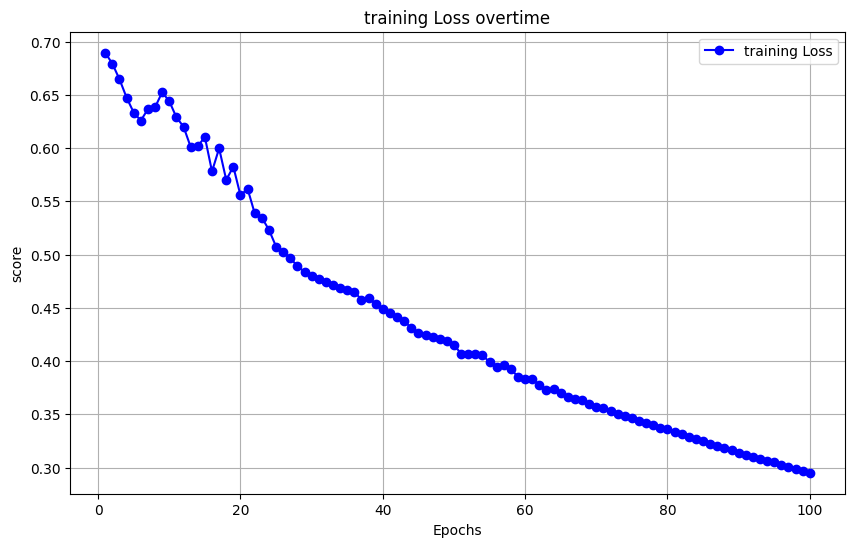

(None, None)

In [8]:
#trains the model, at the end saves the model and plot the validation accuracy and loss function progression
epochs = 100
vals,losses = [],[]
for epoch in  (t := trange(epochs)):
    it = iter(train_set)
    temp_loss = []
    for _ in range(len(train_set)):
        input,target = next(it)
        input,target = input.to(device),target.to(device)
        output = cnn(input).squeeze(1)
        loss = loss_fn(output,target)
        temp_loss.append(loss.item())
        loss.backward()
        opt.step()
    val = validation(test_set,cnn)
    vals.append(val)
    temp_loss = sum(temp_loss)/len(temp_loss)
    losses.append(temp_loss)
    t.set_description(f'validation accuracy: {val:.2f},training loss : {temp_loss:.2f}')
save_model(cnn,opt)
plot(vals,'validation accuracy'),plot(losses,'training Loss')